## 당뇨병 예측 모델 개발


개발 일시: 2022.12.28(목) ~ 2022.12.31(토)

---




1.   데이터 분석 및 시각화
2.   여러 모델을 통해 예측
3.   모델 성능 평가
4.   결언

1. 데이터 분석 및 시각화

**데이터 설명**


---


링크: https://www.kaggle.com/datasets/whenamancodes/predict-diabities

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney
Diseases. The objective of the dataset is to diagnostically predict whether a patient has diabetes,
based on certain diagnostic measurements included in the dataset. Several constraints were placed
on the selection of these instances from a larger database. In particular, all patients here are females
at least 21 years old of Pima Indian heritage.2
From the data set in the (.csv) File We can find several variables, some of them are independent
(several medical predictor variables) and only one target dependent variable (Outcome).

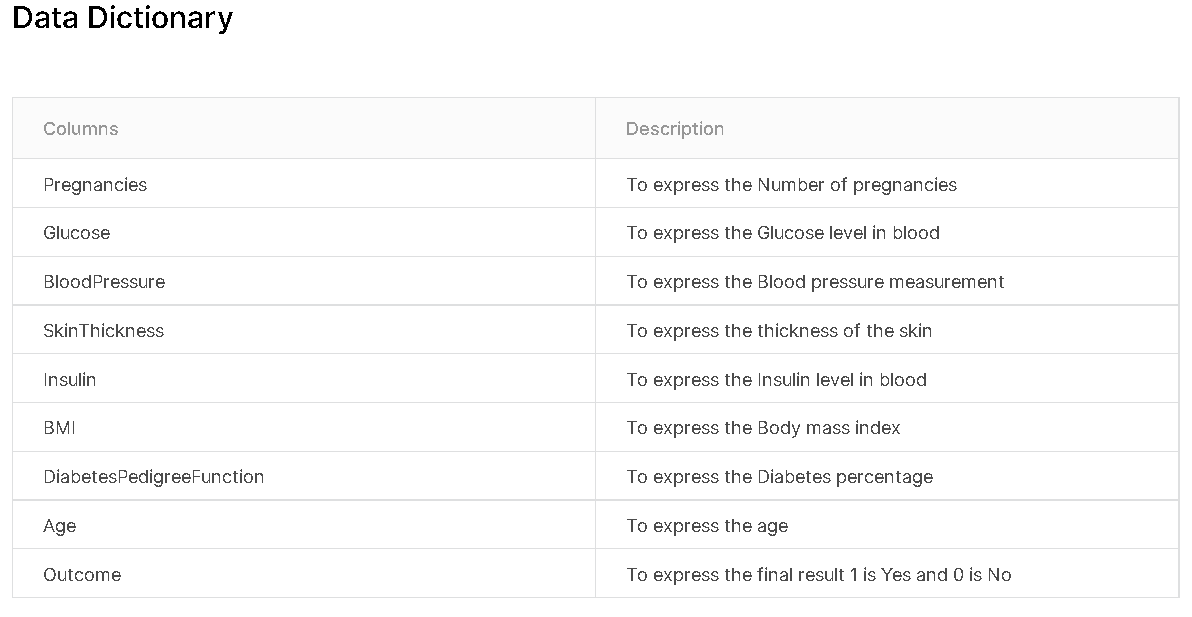

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
import pandas as pd
data = pd.read_csv("/content/drive/MyDrive/diabetes.csv")
print(data)

     Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0              6      148             72             35        0  33.6   
1              1       85             66             29        0  26.6   
2              8      183             64              0        0  23.3   
3              1       89             66             23       94  28.1   
4              0      137             40             35      168  43.1   
..           ...      ...            ...            ...      ...   ...   
763           10      101             76             48      180  32.9   
764            2      122             70             27        0  36.8   
765            5      121             72             23      112  26.2   
766            1      126             60              0        0  30.1   
767            1       93             70             31        0  30.4   

     DiabetesPedigreeFunction  Age  Outcome  
0                       0.627   50        1  
1                  

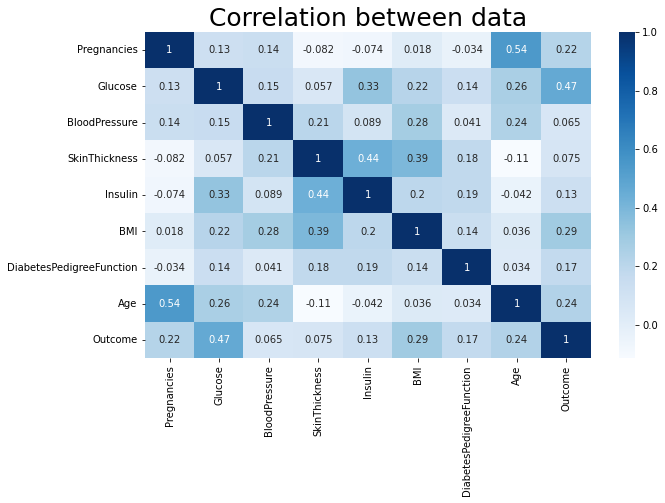

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (10,6))
plt.title("Correlation between data", size = 25)
sns.heatmap(data.corr(),
            cmap = "Blues",
            annot = True)

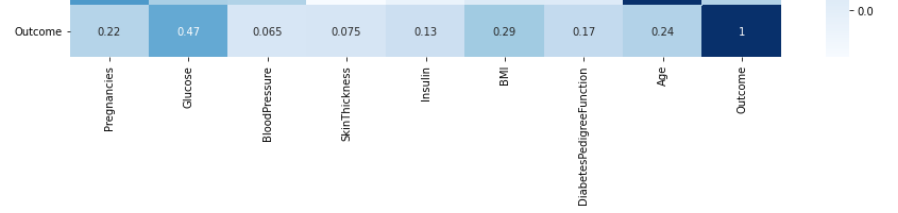



**1.   글루코스와와 당뇨병의 상관관계가 높은 것으로 판단(0.47 상관관계)**
  
-> 포도당(glucose)이란 단당류의 한 종류

**2.   BMI와 당뇨병의 상관관계 분석**

-> BMI(Body Mass Index)는 (몸무게) / (키) ** 2 을 의미하며, 당뇨병이 BMI 와 연관있음을 보여주는 지표(아마 몸무게와 당뇨병 사이에 상관관계가 있음으로 가설)

**3.   나이와 당뇨병병**

-> 고령층일수록, 당뇨병에 취약하다고 판단. 
(대한당뇨병학회(2020), Diabetes fact sheet in Korea 2020.)




1 - (1): 글루코젠과 당뇨병

In [6]:
df_glucose_and_diabetes = pd.DataFrame(
    {"Glucose" : data["Glucose"],
     "Outcome" : data["Outcome"]}
)
print(df_glucose_and_diabetes)

     Glucose  Outcome
0        148        1
1         85        0
2        183        1
3         89        0
4        137        1
..       ...      ...
763      101        0
764      122        0
765      121        0
766      126        1
767       93        0

[768 rows x 2 columns]


Text(0.5, 1.0, 'x | outcome(1 is yes, 0 is no)')

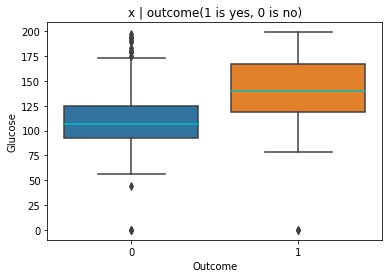

In [7]:
sns.boxplot(y = df_glucose_and_diabetes["Glucose"], 
            x = df_glucose_and_diabetes['Outcome'],
            medianprops=dict(color='c') #중간값 색 설정
            )
plt.title("x | outcome(1 is yes, 0 is no)")

당뇨병 환자는 혈액속 포도당(Glucose) 수치가 높음을 시사함. 

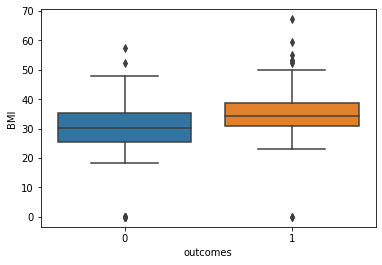

In [8]:
df_BMI_and_outcome = pd.DataFrame(
    {"BMI" : data["BMI"],
    "outcomes" : data["Outcome"]}
)
sns.boxplot(y = df_BMI_and_outcome["BMI"],
              x = df_BMI_and_outcome["outcomes"])

몸무게가 높을수록, 당뇨병이 흔하다는 것을 알 수 있음.

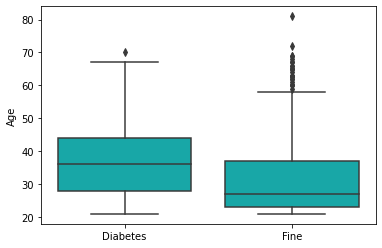

In [9]:
outcome = ["Fine" if each == 0 else "Diabetes" for each in data["Outcome"]] #이런 방법도 있네
outcome = pd.Series(outcome)
sns.boxplot(y = data["Age"],
            x = outcome, color = 'c')

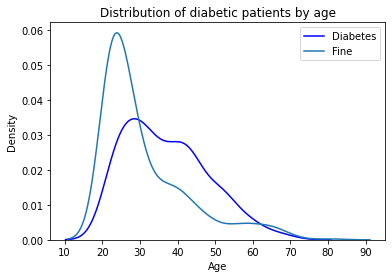

In [10]:
df_Age_and_outcome = data.loc[data["Outcome"] == 1, :]
df_Age_and_outcome2 = data.loc[data["Outcome"] == 0, :]
sns.kdeplot(x = df_Age_and_outcome["Age"], label = "Diabetes", color = "b")
sns.kdeplot(x = df_Age_and_outcome2["Age"], label = "Fine")
plt.legend()
plt.title("Distribution of diabetic patients by age")
plt.show()

나이에 따른 당뇨병 환자 분포
-> 50 - 60 대 사이 환자가 많은 것을 알 수 있음음

## 2. 예측 모델 개발

epoch: 250 | loss: 0.22663


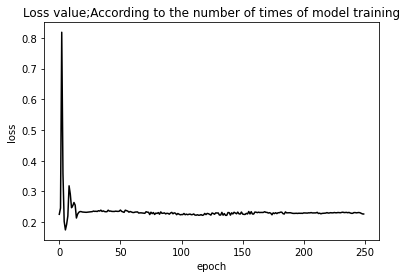

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layer = nn.Sequential(
            nn.Linear(1, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )
    def forward(self, x):
        x = self.flatten(x)
        out = self.layer(x)
        return out
#"____________________________________________________________________________"
train_data = data
torch.manual_seed(55)
device = torch.device("cuda")
model = MLP()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-7)
epochs = 250
loss_list = []
epoch_list = []
for epoch in range(epochs):
  loss = 0.0
  for i in range(768):  
    X = torch.Tensor(train_data.iloc[i, 0:8]).view(-1, 1)
    y_output = train_data.iloc[i, -1]
    Y = torch.Tensor([y_output for _ in range(0, 8)])
    optimizer.zero_grad() 
    outputs = model(X) 
    loss = criterion(outputs, Y) 
    loss.backward()
    optimizer.step() 
    loss += loss.item() 
  loss = round(float(loss), 5)
  loss_list += [loss]
  epoch_list += [epoch]
  if (epoch + 1) % 10 == 0:
    from IPython import display
    display.clear_output(wait = True)
    print(f'epoch: {epoch + 1} | loss: {loss}')
    plt.plot(epoch_list, loss_list, color = "black")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("Loss value;According to the number of times of model training")
    plt.show()

In [12]:
from torchsummary import summary
model.cuda()
summary(model, input_size = (1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                    [-1, 1]               0
            Linear-2                  [-1, 100]             200
              ReLU-3                  [-1, 100]               0
            Linear-4                  [-1, 100]          10,100
              ReLU-5                  [-1, 100]               0
            Linear-6                    [-1, 1]             101
Total params: 10,401
Trainable params: 10,401
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [13]:
from sklearn.model_selection import train_test_split
X = data.iloc[:, 0:-1]
Y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.3, random_state=1
)

**로지스틱회귀분석**

In [44]:
#LogisticRegression
from sklearn.linear_model import LogisticRegression
model_Log = LogisticRegression()
model_Log.fit(X_train, y_train)

LogisticRegression()

In [40]:
model_Log.score(X_test, y_test)

0.7835497835497836

**퍼셉트론**

In [16]:
from sklearn.linear_model import Perceptron
model_Per = Perceptron()
model_Per.fit(X_train, y_train)

Perceptron()

In [17]:
model_Per.score(X_test, y_test)

0.6320346320346321

**SVM**

In [ ]:
from sklearn.svm import SVC
model_SVC = SVC(kernel="linear", C=1e10).fit(X_train, y_train)

In [ ]:
model_SVC.score(X_test, y_test)

**MLP**

In [34]:
import torch
torch.save(model, '/content/drive ')
model_MLP = torch.load('/content/drive ')

TypeError: ignored

**모델 테스트**

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52964 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48652 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50948 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50577 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49457 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47456 missing from current font.
  font.set_

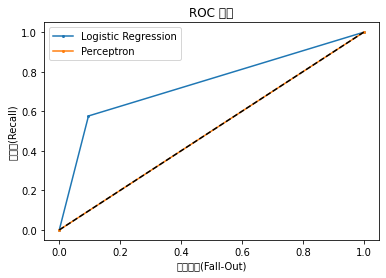

In [48]:
from sklearn.metrics import roc_curve

fpr1, tpr1, thresholds1 = roc_curve(y_test, model_Log.predict(X_test))
fpr2, tpr2, thresholds1 = roc_curve(y_test, model_Per.predict(X_test))
fpr3, tpr3, thresholds1 = roc_curve(y_test, model_SVM.predict(y_test))
plt.plot(fpr1, tpr1, 'o-', ms=2, label="Logistic Regression")
plt.plot(fpr2, tpr2, 'o-', ms=2, label="Perceptron")
plt.plot(fpr3, tpr3, 'o-', ms=2, label="SVM")
plt.legend()
plt.plot([0, 1], [0, 1], 'k--', label="random guess")
plt.xlabel('위양성률(Fall-Out)')
plt.ylabel('재현률(Recall)')
plt.title('ROC 커브')
plt.show()

# **결언**

1. 정형데이터를 처리하는 방법을 공부함.
2. 이미지 데이터 학습 계획
3. classfication 뿐만 아니라 regression 문제도 할 예정.